# Improved EfficientNet-B0 Training Pipeline
This notebook implements several best practices to boost EfficientNet-B0 performance:
1. Weighted sampling for class balance
2. RandAugment + MixUp + CutMix augmentations
3. Label smoothing
4. CosineAnnealingLR with warm restarts
5. Progressive unfreezing
6. Validation threshold tuning for F1

## 1. Imports & Config

In [4]:
import collections
import copy
import os
import subprocess
from datetime import date
import random

import matplotlib.pyplot as plt
from IPython.display import display as IPythonDisplay
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import yaml
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import average_precision_score, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedGroupKFold
from tensorboard.notebook import display
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler
from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
from torchvision.models import EfficientNet_B0_Weights

# load base config and override
with open('../configs/config_best_model.yaml') as f:
    cfg = yaml.safe_load(f)

# Build inference threshold list from config
cfg['inference']['thresholds'] = list(
    np.linspace(
        cfg['inference']['thresholds']['start'],
        cfg['inference']['thresholds']['end'],
        cfg['inference']['thresholds']['num']
    )
)

# device
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print("Using device:", device)

# Reproducibility
seed = cfg.get('seed', 42)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

def clear_memory():
    """Clear GPU memory for both CUDA and MPS"""
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    elif torch.backends.mps.is_available():
        torch.mps.empty_cache()

FIG_OUT = os.path.join('..', 'outputs', 'figures', 'Switzerland', 'finetune_efficientnet_b0')
os.makedirs(FIG_OUT, exist_ok=True)
CP_OUT = os.path.join('..', 'outputs', 'checkpoints', 'Switzerland', 'finetune_efficientnet_b0')
os.makedirs(CP_OUT, exist_ok=True)
CFG_OUT = os.path.join('..', 'outputs', 'configs', 'Switzerland')
os.makedirs(CFG_OUT, exist_ok=True)

today = date.today().isoformat()
commit = subprocess.check_output(["git","rev-parse","--short","HEAD"]).decode().strip()
run_id = f"{today}_{commit}"

print("Run ID :", run_id)

Using device: mps
Run ID : 2025-07-31_a40e6c4


## 2. Transforms & Dataset

In [5]:
# stronger augmentations
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(tuple(cfg['augmentation']['resize']), scale=(0.7,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(cfg['augmentation']['rotation']),
    transforms.ColorJitter(**cfg['augmentation']['color_jitter']),
    transforms.RandAugment(num_ops=2, magnitude=9),
    transforms.ToTensor(),
    transforms.Normalize(mean=cfg['augmentation']['normalization']['mean'],
                         std=cfg['augmentation']['normalization']['std']),
    transforms.RandomErasing(**cfg['augmentation']['random_erasing'])
])
val_transform = transforms.Compose([
    transforms.Resize(tuple(cfg['augmentation']['resize'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=cfg['augmentation']['normalization']['mean'],
                         std=cfg['augmentation']['normalization']['std']),
])

# load dataset
dataset = datasets.ImageFolder(root=os.path.join('..', cfg['data']['path']), transform=train_transform)
# Ensure config matches data
assert cfg['model']['num_classes'] == len(dataset.classes), (
    f"Config num_classes ({cfg['model']['num_classes']}) "
    f"doesn't match dataset classes ({len(dataset.classes)})"
)
# extract groups for StratifiedGroupKFold
groups = [os.path.basename(p).split('_')[0] for p,_ in dataset.samples]
targets = np.array(dataset.targets)
# compute class weights for balanced loss (normalized to average ~1)
class_counts = np.bincount(targets)
num_classes = len(class_counts)
total_samples = len(targets)
class_weights = torch.tensor(
    total_samples / (class_counts * num_classes),
    dtype=torch.float32
).to(device)

## 3. StratifiedGroupKFold + Weighted Sampler Utility

In [12]:
def make_sampler(indices):
    # compute class counts in this subset
    subset_targets = targets[indices]
    class_sample_count = np.bincount(subset_targets)
    # weight per class = 1/count
    weight_per_class = 1.0 / class_sample_count
    # assign a weight to each sample
    sample_weights = weight_per_class[subset_targets]
    # ensure reproducible sampling
    gen = torch.Generator()
    gen.manual_seed(seed)
    return WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True,
        generator=gen
    )


# determine number of splits and initialize splitter
n_splits = min(int(np.unique(groups, return_counts=True)[1].min()), 5)
sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=cfg.get('seed', 42))

# enforce balanced validation class ratio
overall_pos_frac = np.mean(targets == 1)
tolerance = cfg['validation']['tolerance']  # allow ± drift from overall positive fraction
good_folds = []
for tr, vl in sgkf.split(np.zeros(len(targets)), targets, groups):
    val_t = targets[vl]
    # require both classes present
    if len(np.unique(val_t)) < 2:
        continue
    val_frac = np.bincount(val_t)[1] / len(val_t)
    if abs(val_frac - overall_pos_frac) <= tolerance:
        good_folds.append((tr, vl))

# if enough balanced folds found, use them; otherwise fallback
folds = good_folds

# Count positives/negatives in val of fold 1
print(len(folds))
for i in range(len(folds)):
    fold = list(folds)[i]  # Access the first fold
    tr_idx, vl_idx = fold  # Unpack the training and validation indices
    val_targets = targets[vl_idx]
    print(collections.Counter(val_targets))


## 4. Model Factory (EfficientNet-B0 only)
def get_efficientnet_b0(cfg):
    model = models.efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT if cfg['model']['pretrained'] else None)
    in_feats = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(float(cfg['model']['dropout_prob'])),
        nn.Linear(in_feats, cfg['model']['num_classes'])
    )
    return model.to(device)

2
Counter({np.int64(0): 89, np.int64(1): 51})
Counter({np.int64(0): 74, np.int64(1): 63})


In [13]:
class FocalLoss(nn.Module):
    def __init__(self, weight=None, gamma=2, reduction='mean', label_smoothing=0.0):
        super().__init__()
        self.weight = weight
        self.gamma = gamma
        self.reduction = reduction
        self.label_smoothing = label_smoothing
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(
            inputs, targets,
            weight=self.weight,
            reduction='none',
            label_smoothing=self.label_smoothing
        )
        pt = torch.exp(-ce_loss)
        loss = ((1 - pt) ** self.gamma) * ce_loss
        if self.reduction == 'mean':
            return loss.mean()
        return loss.sum()

## 5. MixUp & CutMix Functions

In [14]:
def mixcut(x, y, alpha=0.4, cutmix_prob=0.5):
    if np.random.rand() < cutmix_prob:
        # CutMix
        lam = np.random.beta(alpha, alpha)
        bs, c, h, w = x.size()
        idx = torch.randperm(bs).to(device)
        # bounding box
        cut_w = int(w * np.sqrt(1-lam))
        cut_h = int(h * np.sqrt(1-lam))
        cx = np.random.randint(w)
        cy = np.random.randint(h)
        x0 = max(cx - cut_w//2, 0)
        y0 = max(cy - cut_h//2, 0)
        x1 = min(cx + cut_w//2, w)
        y1 = min(cy + cut_h//2, h)
        x[:,:,y0:y1,x0:x1] = x[idx,:,y0:y1,x0:x1]
        lam = 1 - ((x1-x0)*(y1-y0)/(w*h))
        y_a, y_b = y, y[idx]
    else:
        # MixUp
        lam = np.random.beta(alpha, alpha)
        idx = torch.randperm(x.size(0)).to(device)
        x = lam*x + (1-lam)*x[idx]
        y_a, y_b = y, y[idx]
    return x, y_a, y_b, lam

## 6. Training & Evaluation Functions

In [15]:
def train_one_epoch(model, loader, optimizer, scheduler, criterion):
    model.train()
    running_loss = 0.0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        x, y_a, y_b, lam = mixcut(x,y,
                                  alpha=float(cfg['training']['mixup_alpha']),
                                  cutmix_prob=0.5 if cfg['training']['use_cutmix'] else 0.0)
        optimizer.zero_grad()
        logits = model(x)
        loss = lam*criterion(logits, y_a) + (1-lam)*criterion(logits, y_b)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()*x.size(0)
    return running_loss/len(loader.dataset)

@torch.no_grad()
def evaluate(model, loader, threshold):
    model.eval()
    ys, ps = [], []
    for x,y in loader:
        x = x.to(device)
        logits = model(x)
        prob = F.softmax(logits, dim=1)[:,1].cpu().numpy()
        ys.extend(y.numpy())
        ps.extend(prob)
    preds = (np.array(ps)>=threshold).astype(int)
    return accuracy_score(ys, preds), roc_auc_score(ys, ps), f1_score(ys, preds)

## 7. Full CV Loop for EfficientNet-B0

In [16]:
results = []

for fold_idx, (tr_idx, vl_idx) in enumerate(folds, 1):
    # initialize history for this fold
    history = {'val_loss': []}
    print(f"\n--- Fold {fold_idx}/{len(folds)} ---")
    # subsets
    train_ds = Subset(dataset, tr_idx)
    val_ds   = Subset(datasets.ImageFolder(os.path.join('..',cfg['data']['path']), transform=val_transform), vl_idx)
    # samplers/loaders
    sampler = make_sampler(tr_idx)
    train_loader = DataLoader(train_ds, batch_size=cfg['data']['batch_size'], sampler=sampler,
                              num_workers=cfg['data']['num_workers'])
    val_loader   = DataLoader(val_ds,   batch_size=cfg['data']['batch_size'], shuffle=False,
                              num_workers=cfg['data']['num_workers'])
    # model
    model = get_efficientnet_b0(cfg)
    # use focal loss with class weights
    criterion = FocalLoss(
        weight=class_weights,
        gamma=2,
        reduction='mean',
        label_smoothing=float(cfg['training']['label_smoothing'])
    ).to(device)
    # optimizer & scheduler
    optimizer = optim.AdamW(
        model.parameters(),
        lr=float(cfg['training']['learning_rate']),
        weight_decay=float(cfg['training']['weight_decay'])
    )
    scheduler = optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=cfg['training']['epochs'],
        eta_min=1e-6
    )

    # -- head warmup --
    for name,param in model.named_parameters():
        param.requires_grad = name.startswith('classifier')
    for epoch in range(3):
        loss = train_one_epoch(model, train_loader, optimizer, scheduler, criterion)
        print(f"Warmup E{epoch+1}/3 loss: {loss:.4f}")
    # -- unfreeze all --
    for param in model.parameters():
        param.requires_grad = True
    # re-init optimizer/scheduler
    optimizer = optim.AdamW(
        model.parameters(),
        lr=float(cfg['training']['learning_rate']),
        weight_decay=float(cfg['training']['weight_decay'])
    )
    scheduler = optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=cfg['training']['epochs'],
        eta_min=1e-6
    )

    # fine-tune with early stopping and fixed-threshold validation
    best_f1 = 0
    best_epoch = -1
    best_state = None

    for epoch in range(cfg['training']['epochs']):
        loss = train_one_epoch(model, train_loader, optimizer, scheduler, criterion)
        acc, auc, f1_val = evaluate(model, val_loader, threshold=0.5)
        print(f"Epoch {epoch+1}/{cfg['training']['epochs']}: loss {loss:.4f} | val_acc {acc:.3f} | val_auc {auc:.3f} | val_f1 {f1_val:.3f} (thr=0.50)")
        # Compute and record validation loss
        model.eval()
        val_losses = []
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            logits_val = model(x_val)
            loss_val = criterion(logits_val, y_val)
            val_losses.append(loss_val.item() * x_val.size(0))
        avg_val_loss = sum(val_losses) / len(val_loader.dataset)
        history['val_loss'].append(avg_val_loss)
        if f1_val > best_f1:
            best_f1 = f1_val
            best_epoch = epoch
            best_state = copy.deepcopy(model.state_dict())
        if epoch - best_epoch >= cfg['training']['patience']:
            print(f"Stopping early at epoch {epoch+1}")
            break
        # Step LR scheduler per epoch
        scheduler.step()
    # reload best model state
    model.load_state_dict(best_state)
    # threshold tuning on best model
    best_thr, best_thr_f1 = 0.5, 0
    for thr in cfg['inference']['thresholds']:
        _, _, f1_val = evaluate(model, val_loader, thr)
        if f1_val > best_thr_f1:
            best_thr_f1, best_thr = f1_val, thr
    acc, auc, f1_val = evaluate(model, val_loader, best_thr)
    print(f"Best tuned threshold: {best_thr:.2f}, F1: {f1_val:.2f}, Acc: {acc:.2f}")
    # Collect per-fold detailed results
    # Gather true labels and probabilities
    y_true, y_prob = [], []
    for x_val, y_val in val_loader:
        x_val = x_val.to(device)
        logits_val = model(x_val)
        probs = torch.softmax(logits_val, dim=1)[:,1].detach().cpu().numpy()
        y_true.extend(y_val.numpy())
        y_prob.extend(probs)
    y_pred = (np.array(y_prob) >= best_thr).astype(int)
    # Compute reports and matrices
    report = classification_report(y_true, y_pred, output_dict=True)
    cm = confusion_matrix(y_true, y_pred)
    avg_pr = average_precision_score(y_true, y_prob)

    results.append({
        'fold': fold_idx,
        'roc_auc': auc,
        'best_thr': best_thr,
        'average_precision': avg_pr,
        'accuracy': accuracy_score(y_true, y_pred),
        'report': report,
        'history': history,
        'y_true': y_true,
        'y_prob': y_prob,
        'confusion_matrix': cm
    })

    # Save best model for this fold
    fold_dir = os.path.join(CP_OUT, f'fold_{fold_idx}')
    os.makedirs(fold_dir, exist_ok=True)
    torch.save(best_state, os.path.join(fold_dir, 'best_model.pth'))


--- Fold 1/2 ---
Warmup E1/3 loss: 0.1820
Warmup E2/3 loss: 0.1885
Warmup E3/3 loss: 0.1832
Epoch 1/30: loss 0.1654 | val_acc 0.600 | val_auc 0.619 | val_f1 0.472 (thr=0.50)
Epoch 2/30: loss 0.1626 | val_acc 0.650 | val_auc 0.760 | val_f1 0.566 (thr=0.50)
Epoch 3/30: loss 0.1601 | val_acc 0.736 | val_auc 0.828 | val_f1 0.667 (thr=0.50)
Epoch 4/30: loss 0.1589 | val_acc 0.750 | val_auc 0.844 | val_f1 0.639 (thr=0.50)
Epoch 5/30: loss 0.1538 | val_acc 0.843 | val_auc 0.918 | val_f1 0.800 (thr=0.50)
Epoch 6/30: loss 0.1452 | val_acc 0.857 | val_auc 0.910 | val_f1 0.815 (thr=0.50)
Epoch 7/30: loss 0.1399 | val_acc 0.857 | val_auc 0.924 | val_f1 0.815 (thr=0.50)
Epoch 8/30: loss 0.1429 | val_acc 0.850 | val_auc 0.920 | val_f1 0.811 (thr=0.50)
Epoch 9/30: loss 0.1512 | val_acc 0.879 | val_auc 0.922 | val_f1 0.841 (thr=0.50)
Epoch 10/30: loss 0.1386 | val_acc 0.836 | val_auc 0.918 | val_f1 0.785 (thr=0.50)
Epoch 11/30: loss 0.1304 | val_acc 0.843 | val_auc 0.924 | val_f1 0.792 (thr=0.50)
Epo

In [17]:
# Compute average threshold across folds
best_thrs = [r['best_thr'] for r in results]
avg_thr = sum(best_thrs) / len(best_thrs)
print(f'Average threshold across folds: {avg_thr:.2f}')

clear_memory()

# Train final model on all data
full_dataset = ImageFolder(root=os.path.join('..', cfg['data']['path']), transform=train_transform)
full_loader = DataLoader(full_dataset, batch_size=cfg['data']['batch_size'],
                         sampler=make_sampler(range(len(full_dataset))), num_workers=cfg['data']['num_workers'])
model = get_efficientnet_b0(cfg)
criterion = FocalLoss(
    weight=class_weights,
    gamma=2,
    reduction='mean',
    label_smoothing=float(cfg['training']['label_smoothing'])
).to(device)
optimizer = optim.AdamW(
    model.parameters(),
    lr=float(cfg['training']['learning_rate']),
    weight_decay=float(cfg['training']['weight_decay'])
)
scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=cfg['training']['epochs'],
    eta_min=1e-6
)
for epoch in range(cfg['training']['epochs']):
    loss = train_one_epoch(model, full_loader, optimizer, scheduler, criterion)
    print(f"Full training Epoch {epoch + 1}/{cfg['training']['epochs']} loss: {loss:.4f}")
    # Step LR scheduler per epoch
    scheduler.step()
# Save general model
general_model_path = os.path.join(CP_OUT, f'{run_id}_general_model.pth')
torch.save(model.state_dict(), general_model_path)
print(f'General model saved to {general_model_path}')

Average threshold across folds: 0.53
Full training Epoch 1/30 loss: 0.1809
Full training Epoch 2/30 loss: 0.1676
Full training Epoch 3/30 loss: 0.1534
Full training Epoch 4/30 loss: 0.1521
Full training Epoch 5/30 loss: 0.1601
Full training Epoch 6/30 loss: 0.1511
Full training Epoch 7/30 loss: 0.1398
Full training Epoch 8/30 loss: 0.1397
Full training Epoch 9/30 loss: 0.1370
Full training Epoch 10/30 loss: 0.1399
Full training Epoch 11/30 loss: 0.1269
Full training Epoch 12/30 loss: 0.1328
Full training Epoch 13/30 loss: 0.1344
Full training Epoch 14/30 loss: 0.1334
Full training Epoch 15/30 loss: 0.1353
Full training Epoch 16/30 loss: 0.1277
Full training Epoch 17/30 loss: 0.1262
Full training Epoch 18/30 loss: 0.1216
Full training Epoch 19/30 loss: 0.1295
Full training Epoch 20/30 loss: 0.1245
Full training Epoch 21/30 loss: 0.1213
Full training Epoch 22/30 loss: 0.1348
Full training Epoch 23/30 loss: 0.1322
Full training Epoch 24/30 loss: 0.1288
Full training Epoch 25/30 loss: 0.12

# 8. Metrics Visualization

In [18]:
# 8.1 Metrics Summary
df_results = pd.DataFrame([{
    'fold': r['fold'],
    'roc_auc': r['roc_auc'],
    'average_precision': r['average_precision'],
    'accuracy': r['accuracy']
} for r in results]).set_index('fold')

csv_path = os.path.join(FIG_OUT, f"{run_id}_folds_metrics_report.csv")
df_results.to_csv(csv_path, index=True)

print("\n=== Summary EfficientNet-B0 ===")
IPythonDisplay(df_results)
print("\nMean ± std deviation:")
print(df_results.mean().rename('mean').to_frame().join(df_results.std().rename('std').to_frame()))


=== Summary EfficientNet-B0 ===


,roc_auc,average_precision,accuracy
fold,,,
1,0.962106,0.942996,0.900000
2,0.967181,0.965511,0.919708



Mean ± std deviation:
                       mean       std
roc_auc            0.964644  0.003589
average_precision  0.954253  0.015920
accuracy           0.909854  0.013936


<Figure size 800x500 with 0 Axes>

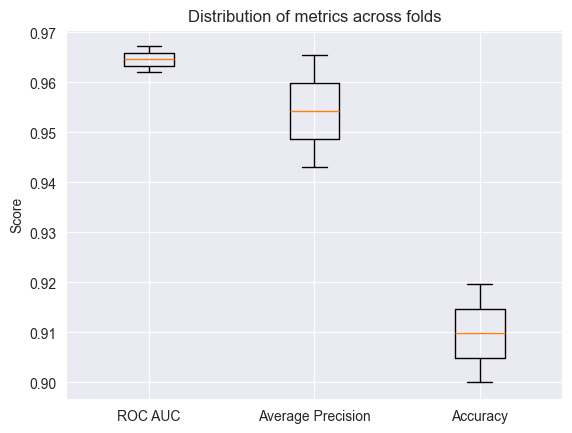

In [19]:
# 8.2 Metrics Boxplots
plt.figure(figsize=(8,5))
plt.figure()
plt.boxplot([
    df_results['roc_auc'],
    df_results['average_precision'],
    df_results['accuracy']
], tick_labels=['ROC AUC', 'Average Precision', 'Accuracy'])
plt.title("Distribution of metrics across folds")
plt.ylabel("Score")
plt.savefig(os.path.join(FIG_OUT, f"{run_id}_folds_metrics.png"), dpi=300)
plt.show()

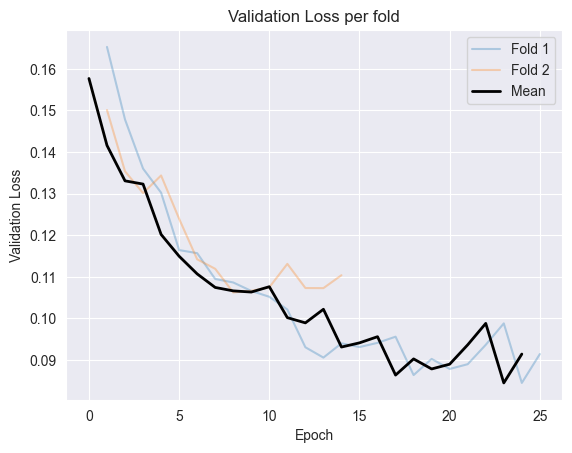

In [20]:
# 7.3 Per-fold Validation Loss Curves
plt.figure()
for r in results:
    epochs = range(1, len(r['history']['val_loss'])+1)
    plt.plot(epochs, r['history']['val_loss'], alpha=0.3, label=f"Fold {r['fold']}")
# Mean validation loss
mean_val = pd.DataFrame([r['history']['val_loss'] for r in results]).mean()
epochs = mean_val.index
plt.plot(epochs, mean_val, color='black', linewidth=2, label='Mean')
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Validation Loss per fold")
plt.legend()
plt.savefig(os.path.join(FIG_OUT, f"{run_id}_folds_loss.png"), dpi=300)
plt.show()

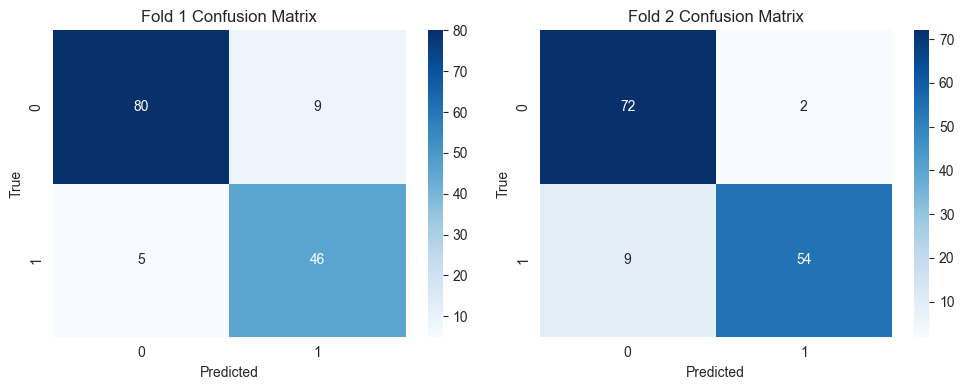

In [25]:
# 7.4 Per-fold Confusion Matrices
fig, axes = plt.subplots(1, len(results), figsize=(5 * len(results), 4))
if len(results) == 1:
    axes = [axes]
for r, ax in zip(results, axes):
    sns.heatmap(r['confusion_matrix'], annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f"Fold {r['fold']} Confusion Matrix")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
plt.tight_layout()
plt.savefig(os.path.join(FIG_OUT, f"{run_id}_confusion_matrices.png"), dpi=300)
plt.show()

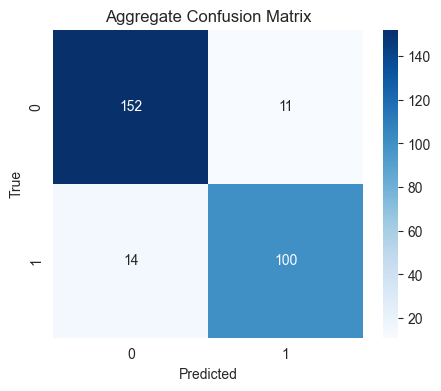

In [26]:
# 7.5 Aggregate Confusion Matrix
agg_cm = sum(r['confusion_matrix'] for r in results)
plt.figure(figsize=(5, 4))
sns.heatmap(agg_cm, annot=True, fmt='d', cmap='Blues')
plt.title("Aggregate Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig(os.path.join(FIG_OUT, f"{run_id}_aggregate_confusion_matrix.png"), dpi=300)
plt.show()

# 9. Save configuration

In [32]:
with open(os.path.join(CFG_OUT, f'{run_id}_config_finetune_efficientnet_b0.yaml'), 'w') as f:
    yaml.dump(cfg, f)

clear_memory()

print('Training complete. Model and config saved.')

Training complete. Model and config saved.


# 10. Testing

In [36]:
# 10.2 Dataset class
class OutOfGroupDataset(ImageFolder):
    def __init__(self, root, transform=None):
        super().__init__(root=root, transform=transform)

In [37]:
# 10.2 Testing
# Load test dataset (out-of-group)
test_transform = val_transform
test_dataset = OutOfGroupDataset(root=os.path.join('..', 'data/raw/test'), transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=cfg['data']['batch_size'], shuffle=False, num_workers=0)

In [38]:
# 10.2.a Test each fold model
print("Testing each fold model on out-of-group test set")

for fold_idx in range(1, len(results)+1):
    fold_ckpt = os.path.join(CP_OUT, f'fold_{fold_idx}', 'best_model.pth')
    model = get_efficientnet_b0(cfg)
    model.load_state_dict(torch.load(fold_ckpt))
    model.eval()
    fold_preds, fold_probs, fold_targets = [], [], []
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            logits = model(x)
            probs = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()
            preds = (probs >= avg_thr).astype(int)
            fold_preds.extend(preds)
            fold_probs.extend(probs)
            fold_targets.extend(y.numpy())
    print(f"Fold {fold_idx} Test ROC AUC: {roc_auc_score(fold_targets, fold_probs):.4f} "
          f"F1: {f1_score(fold_targets, fold_preds):.4f}")

Testing each fold model on out-of-group test set
Fold 1 Test ROC AUC: 0.6481 F1: 0.6667
Fold 2 Test ROC AUC: 0.5337 F1: 0.5236


In [39]:
# 10.2.b Test model
# Load model
ckpt_path = os.path.join(CP_OUT, f'{run_id}_general_model.pth')
model = get_efficientnet_b0(cfg)
model.load_state_dict(torch.load(ckpt_path))
model = model.to(device)
model.eval()

# Evaluate on test set
print(f"Testing using average threshold {avg_thr:.2f}")
all_preds = []
all_probs = []
all_targets = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        logits = model(x)
        probs = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()
        preds = (probs >= avg_thr).astype(int)
        all_preds.extend(preds)
        all_probs.extend(probs)
        all_targets.extend(y.numpy())

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, \
    average_precision_score

print("Test Set Performance:")
print(classification_report(all_targets, all_preds))
print("Confusion Matrix:")
print(confusion_matrix(all_targets, all_preds))
print(f"Accuracy: {accuracy_score(all_targets, all_preds):.4f}")
print(f"ROC AUC: {roc_auc_score(all_targets, all_probs):.4f}")
print(f"Average Precision: {average_precision_score(all_targets, all_probs):.4f}")

Testing using average threshold 0.53
Test Set Performance:
              precision    recall  f1-score   support

           0       0.58      0.39      0.47        99
           1       0.51      0.69      0.58        90

    accuracy                           0.53       189
   macro avg       0.55      0.54      0.53       189
weighted avg       0.55      0.53      0.52       189

Confusion Matrix:
[[39 60]
 [28 62]]
Accuracy: 0.5344
ROC AUC: 0.5471
Average Precision: 0.4937
